#Classes to be implemented


*   TheWorld
*   User
*   AI_Assistant
    *   Environment
    *   Planner
    *   UserModel





In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.stats import bernoulli
import copy

#Utils

In [2]:
def dec2bin(n, n_digs=None):
    num = bin(n).replace("0b","")
    if n_digs:
        num = "0"*(n_digs-len(num))+num
    return num
    

def bin2dec(n):
    return int(n,2)



#The World

In [3]:
class Route:
    def __init__(self, start, end, mode=None,
                    cost=None, time=None, dist=None):
        self.start = start
        self.end = end
        self.mode = mode
        self.cost = cost
        self.time = time
        self.dist = dist

In [7]:
class World:
    def __init__(self, n_cities, n_modes, modes_prob, modes_cost, modes_time, modes_dist):
        self.n_cities = n_cities
        self.n_modes = n_modes
        self.modes_prob = modes_prob
        self.bin_edges = None
        self.graph = nx.Graph()
        self._generate_random_map()
        self.start, self.destination = np.random.choice(self.n_cities, size=(2,), replace=False)
        self.path_ai, self.path_user = None, None
        # generate cost, duration and other factors for the graph
        self.costs = self._generate_properties(modes_cost)
        self.times = self._generate_properties(modes_time)
        self.dists = self._generate_properties(modes_dist)
        self._find_best_pos()


    def step(self, ai_advice=None, user_action=None):
        if ai_advice is not None and self._is_valid(ai_advice):
            self.path_ai = []
            for x,y,m in ai_advice:
                self.path_ai.append(Route(x, y, m, cost=self.costs[x,y,m], time=self.times[x,y,m], dist=self.dists[x,y,m]))
        if user_action is not None and self._is_valid(user_action):
            self.path_user = []
            for x,y,m in user_action:
                self.path_user.append(Route(x, y, m, cost=self.costs[x,y,m], time=self.times[x,y,m], dist=self.dists[x,y,m]))

    def _is_valid(self, path):
        valid = True
        for x,y,m in path:
            if self.bin_edges[x][y][m] == "0":
                valid = False
                break
        if not valid:
            print("Invalid pathway!")
        return valid

    def display_path(self):
        plt.figure(figsize=(14,12))
        ax = plt.gca()
        ax.set_title("Current Path")
        G = nx.Graph()
        nx.draw_networkx_nodes(G, self.nodes_pos, nodelist=[str(i) for i in range(self.n_cities)],
                               node_color="tab:red", node_size=800, alpha=0.9)
        if self.path_ai is not None:
            nx.draw_networkx_edges(G, self.nodes_pos, edgelist=[(str(route.start), str(route.end)) for route in self.path_ai], width=7, edge_color='blue', alpha=0.5)
            nx.draw_networkx_edge_labels(G, self.nodes_pos, edge_labels={(str(route.start), str(route.end)):"mode: "+str(route.mode) for route in self.path_ai},
                                         label_pos=0.6, font_size=9, font_color='blue', alpha=0.8, horizontalalignment='center', verticalalignment='bottom')
        if self.path_user is not None:
            nx.draw_networkx_edges(G, self.nodes_pos, edgelist=[(str(route.start), str(route.end)) for route in self.path_user], width=7, edge_color='green', alpha=0.6)
            nx.draw_networkx_edge_labels(G, self.nodes_pos, edge_labels={(str(route.start), str(route.end)):"mode: "+str(route.mode) for route in self.path_user},
                                         label_pos=0.4, font_size=9, font_color='green', alpha=0.8, horizontalalignment='center', verticalalignment='top')
        nx.draw_networkx_labels(G, self.nodes_pos, {str(i):str(i) for i in range(self.n_cities)}, font_size=20, font_weight="bold", font_color="whitesmoke")
        nx.draw_networkx_nodes(G, self.nodes_pos, nodelist=[str(self.start),str(self.destination)], node_color="purple")
        _ = ax.axis('off')
        plt.show()

    def display(self):
        n_rows = int(np.ceil(self.n_modes/3))
        plt.figure(figsize=(21, 6*n_rows))
        for i in range(self.n_modes):
            plt.subplot(n_rows, 3, i+1)
            self.display_mode(i)
        plt.show()

    def display_mode(self, mode):
        #plt.figure(figsize=(12,9))
        ax = plt.gca()
        ax.set_title("Transport mode: " + str(mode))
        G = nx.Graph()
        for i in range(self.n_cities):
            for j in range(self.n_cities):
                if self.bin_edges[i][j][mode] == "1":
                    G.add_edge(str(i), str(j))
        nx.draw(G, self.nodes_pos, ax=ax, with_labels=True, width=3, edge_color='grey', font_color="whitesmoke",
                font_weight="bold", font_size=20, node_color="tab:red", node_size=800, alpha=0.9)
        nx.draw_networkx_nodes(G, self.nodes_pos, nodelist=[str(self.start),str(self.destination)], node_color="purple")
        _ = ax.axis('off')
        #plt.show()

    def _find_best_pos(self):
        plt.figure(figsize=(7,6))
        G = nx.Graph()
        for i in range(self.n_cities):
            for j in range(self.n_cities):
                if "1" in self.bin_edges[i][j]:
                    G.add_edge(str(i), str(j))
        self.nodes_pos = nx.kamada_kawai_layout(G)
        plt.show("off")
        

    def _encrypt_route(self, start, end):
        return str(start)+"#"+str(end)

    def _decrypt_rout(self, key):
        start, end = key.split("#")
        return int(start), int(end)

    def _generate_random_map(self):
        edges_dec = np.zeros((self.n_cities, self.n_cities)).astype(np.int16)
        for i in range(self.n_cities):
            for j in range(i):
                if np.random.random() < self.modes_prob:
                    edges_dec[i][j] = edges_dec[j][i] = np.random.randint(2**self.n_modes)
        self.bin_edges = [[dec2bin(edge, self.n_modes) for edge in row] for row in edges_dec]

        # pass information to graph
        self.graph.add_nodes_from(range(1,self.n_cities+1))
        for c,city in enumerate(self.bin_edges):
            mode_mask = ['1' in mode for mode in city]
            edge_ind = [i for i,x in enumerate(mode_mask) if x]
            self.graph.add_edges_from([(c,ind) for ind in edge_ind])
    
    def _generate_properties(self, modes_args):
        props = np.zeros((self.n_cities, self.n_cities, self.n_modes))
        for i in range(self.n_cities):
            for j in range(i):
                for m in range(self.n_modes):
                    if self.bin_edges[i][j][m] == "1":
                        props[i][j][m] = props[j][i][m] = np.random.normal(*modes_args[m])
                    else:
                        props[i][j][m] = props[j][i][m] = np.inf
        return props



#User

In [8]:
class User:
    def __init__(self,**kwargs):
        self.world_setup = None
        self.user_params = kwargs.get('user_param', np.random.normal(size=(1,3)))
        self.error = np.random.uniform(0,.3)
        self.observations = []


    def take_action(self):
        last_ai = self.observations[-1]
        ai_advice = [(r.start,r.end,r.mode) for r in last_ai]
        segment_costs = [self._calc_segment_cost(segment) for segment in ai_advice]

        actions, action_prob = self.user_policy(ai_advice)

        preferred_ind = np.random.choice(range(len(actions)), p=action_prob)        
        return actions[preferred_ind]
        
        
    def user_policy(self, ai_advice):
        segment_costs = [self._calc_segment_cost(segment) for segment in ai_advice]
        advice_cost = np.sum(segment_costs)

        # COULD DO: make Boltzmann ration as well
        most_costly = np.argmax(segment_costs)
        alt_dict = self._find_alternatives(ai_advice,most_costly)

        all_paths,cost_vec = [],[]
        for journey, cost in alt_dict.items():
            new_path = copy.copy(ai_advice)
            new_costs = copy.copy(segment_costs)
            if len(journey)==3:
                new_path[most_costly] = journey
                new_costs[most_costly] = cost
                
            elif len(journey)==2:
                part1, part2 = journey
                new_path[most_costly] = part1
                new_path.insert(most_costly+1,part2)
                new_costs[most_costly] = cost
            all_paths.append(new_path)
            cost_vec.append(np.sum(new_costs))

        utility = -1*np.array(cost_vec)
        policy_space = np.exp(utility)/np.sum(np.exp(utility))

        # COULD DO: In case we need more stochasticity
        # make_error = bernoulli(self.error)
        # if make_error:
        #     new_path_dict.drop(preferred_path)
        #     return np.random.choice(list(new_path_dict.values()))
        return all_paths, policy_space

    def _calc_segment_cost(self,segment):
        cost_vec = np.array([self.world_setup['costs'][segment], 
                              self.world_setup['times'][segment],
                              self.world_setup['dists'][segment]])
        return self.user_params.dot(cost_vec)
    
    def _find_alternatives(self,path,prob_ind):
        alt_dict = dict()
        start, mid_pt, mode = path[prob_ind]
        
        # change mode of transport
        bin_modes = self.world_setup['edges'][start, mid_pt]
        alt_modes = [i for i, val in enumerate(bin_modes) if val=='1']
        for mode_num in alt_modes:
            new_mode = (start,mid_pt,mode_num)
            alt_dict[new_mode] = self._calc_segment_cost(new_mode)
        
        if path[prob_ind] == path[-1]:
            return alt_dict
        
        # find alternative transfer routes
        _, end, mode = path[prob_ind+1]
        ## skip
        bin_direct = self.world_setup['edges'][start, end]
        alt_direct = [i for i, val in enumerate(bin_direct) if val=='1']
        for mode_num in alt_direct:
            new_direct = (start,end,mode_num)
            alt_dict[new_direct] = self._calc_segment_cost(new_direct)

        ## change transfer
        alt_transfer1 = self.world_setup['edges'][start, :]
        for mid_pt, bin_transfer1 in enumerate(alt_transfer1):
            txn_dict = dict()
            alt_tnx1 = [i for i, v in enumerate(bin_transfer1) if v=='1']
            for mode_num in alt_tnx1:
                txn1 = (start,mid_pt,mode_num)
                txn_dict[txn1] = self._calc_segment_cost(txn1)
            bin_tnx2 = self.world_setup['edges'][mid_pt, end]
            alt_tnx2 = [i for i, v in enumerate(bin_tnx2) if v=='1']
            for mode_num in alt_tnx2:
              txn2 = (mid_pt,end,mode_num)
              cost2 = self._calc_segment_cost(txn2)
              for txn1,cost1 in txn_dict.items():
                  alt_dict[(txn1,txn2)] = cost1 + cost2

        return alt_dict

    def observe(self,state):
        # If first time seeing the board
        if self.world_setup is None:
            self.world_setup = dict()
            self.world_setup['edges'] = np.array(state.bin_edges)
            self.world_setup['costs'] = state.costs
            self.world_setup['times'] = state.times
            self.world_setup['dists'] = state.dists
        if state.path_ai is not None:
            self.observations.append(state.path_ai)

#Agent

In [ ]:
class Assistant:
    # MLE infer user params
    # plan assuming MLE
    def __init__(self):
        self.user_model = None
        self.planner = None
        self.env = None
        self.observations = []

    def take_action(self):
        best_action = self.planner.recommend(self.env, self.user_model)
        return best_action

    def observe(self, obs):
        if self.env is None:
            self.env = Env(obs) #,self.user_model)
        self.user_model.update(obs)
        self.env.update(obs)
        self._update(obs)
        #store observations if neeeded
        self.observations.append(obs)

    def _update(self, obs):
        pass

In [ ]:
class Planner:
    def __init__(self):
        pass

    def _plan(self):
        pass

    def _select_best(self):
        pass

    def recommend(self,env,user_model):
        param_sample = user_model.sample()
        all_actions = env.getPossibleActions()
        action = self._select_best(all_actions)
        return action


In [ ]:
class Env:
    def __init__(self,world_state,user_model):
        self.init_state = world_state
        self.user_model = user_model
        self.start = world_state.start
        self.destination = world_state.destination
        self.bin_edges = np.array(world_state.bin_edges)
        self.costs = world_state.costs
        self.times = world_state.times
        self.dists = world_state.dists
        self._gen_solutions()

    def _gen_solutions(self):
        self.all_roads = list(nx.all_simple_paths(self.init_state.graph, 
                                                  source=self.start, 
                                                  target=self.destination))
        
        # Generate modes for known task connections
        self.modes_dict = dict()
        self.path_tuples = []
        for road in self.all_roads:
            cur_path = []
            for segment in range(len(road)-1):
                c_begin, c_end = road[segment], road[segment+1]
                cur_path.append((c_begin, c_end))
                if (c_begin,c_end) not in modes_dict.keys():
                    # which mode is available?
                    modes_list = world.bin_edges[c_begin][c_end]
                    mode_mask = ['1' in mode for mode in modes_list]
                    mode_ind = [i for i,x in enumerate(mode_mask) if x]
                    self.modes_dict[(c_begin,c_end)] = mode_ind
            self.path_tuples.append(cur_path)
                
    
    # def step(self, action):
    #     pass

    def update(self, obs):
        # infer new params based on obs
        # step 1: find difference + calculate cost difference (also consider choice?)

    def getCurrentPlayer(self):
        return 1

    def getPossibleActions(self):
        actions = []
        for route in self.path_tuples:
            route_options = []
            for segment in route:
                modes = self.modes_dict[segment]
                for mode in modes:
                    route_options.append()



    def takeAction(self, action):
        raise NotImplementedError()

    def isTerminal(self):
        return self.init_state.path_ai == self.init_state.path_user
        

    def getReward(self):
        # only needed for terminal states
        raise NotImplementedError()

    def __eq__(self, other):
        raise NotImplementedError()

In [ ]:
class UserModel:
    def __init__(self):
        pass

    def take_action(self):
        pass

    def update(self, obs):
        pass

#Details

We consider there exist 10 cities, each could be connected to others with several different transportation mode. We consider there exist 5 different transportation mode, each could be represented by a graph $G_i=(V, E_i)$ where V are the cities and $E_i$ shows the connections for transportation mode $i$.

The aim of the sequential interaction is to build a path between given starting point and destination and defining a mode of transfer for each route in it.


##Initializing the world



<Figure size 504x432 with 0 Axes>

Starting point: 7
Destination: 5


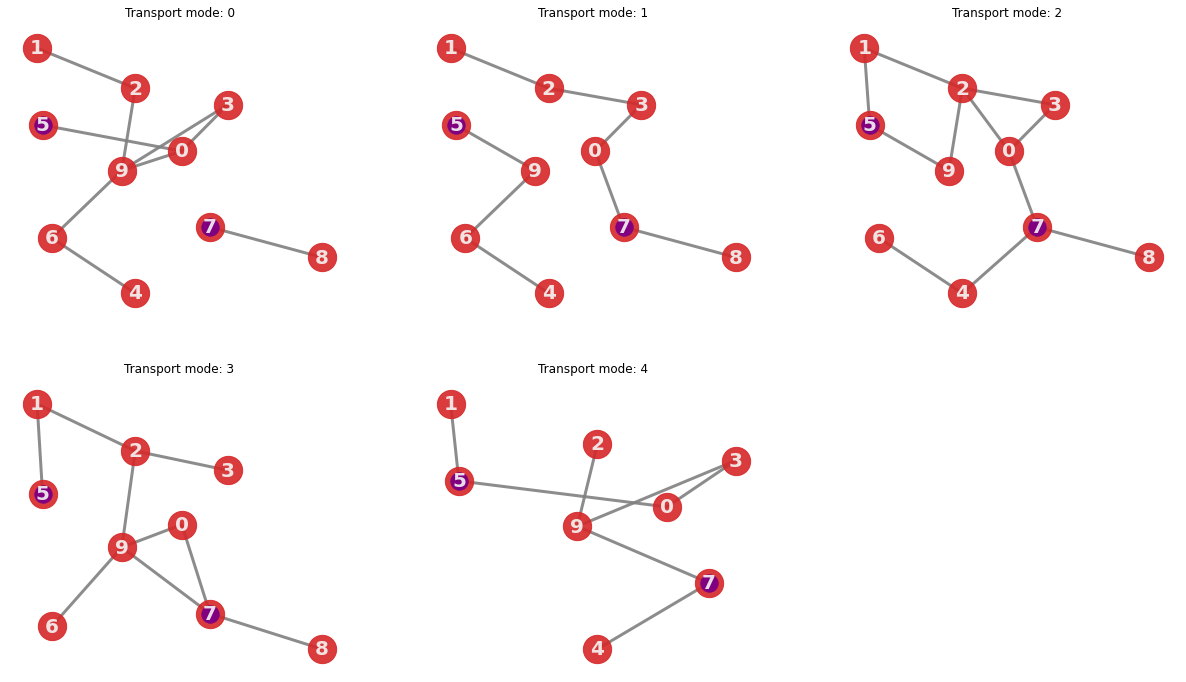

In [9]:
np.random.seed(12345)

N_CITIES = 10
N_MODES = 5

modes_prob = 0.6    # prob of each edge to be existed
modes_cost = [(2*i+1, 1) for i in range(N_MODES)]     # The higher the mode index, more expensive and faster. ## cost = mu + |e| where e~N(0,1) ##
modes_time = [(10*(N_MODES-i), 5) for i in range(N_MODES)]
modes_dist = [(1, 0.2) for i in range(N_MODES)] # same for all for now



world = World(N_CITIES, N_MODES, modes_prob, modes_cost, modes_time, modes_dist)
print("Starting point:", world.start)
print("Destination:", world.destination)
#for i in range(world.n_cities):
    #print(world.edges[i])
world.display()

### AI's advice example

In [11]:
ai_advice = [(7, 0, 2), (0, 3, 0), (3, 2, 1), (2, 1, 3), (1, 5, 4)]
world.step(ai_advice=ai_advice)

###User's action example

In [13]:
user_action = [(7, 0, 2), (0, 3, 0), (3, 2, 1), (2, 9, 2), (9, 5, 2)]
world.step(user_action=user_action)

### Displaying the current path

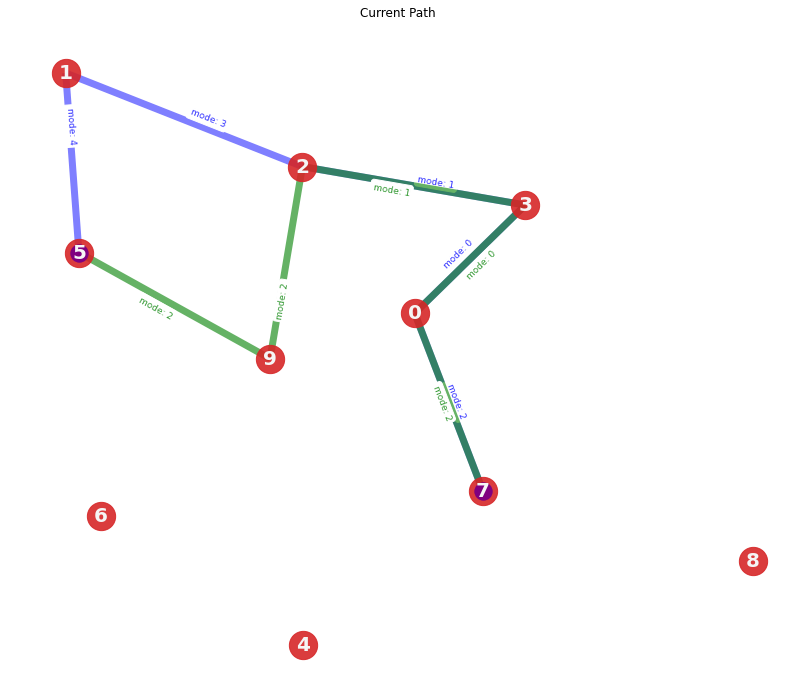

In [14]:
world.display_path()

In [15]:
# OPTIONAL setting
# human = User(user_param=np.array([.2,.2,.2]))
human = User()
human.observe(world)
human.user_policy(ai_advice)

([[(7, 0, 2), (0, 3, 0), (3, 2, 1), (2, 1, 3), (1, 5, 2)],
  [(7, 0, 2), (0, 3, 0), (3, 2, 1), (2, 1, 3), (1, 5, 3)],
  [(7, 0, 2), (0, 3, 0), (3, 2, 1), (2, 1, 3), (1, 5, 4)]],
 array([9.83121887e-01, 1.64096278e-02, 4.68484866e-04]))

In [ ]:
user_action = human.take_action()

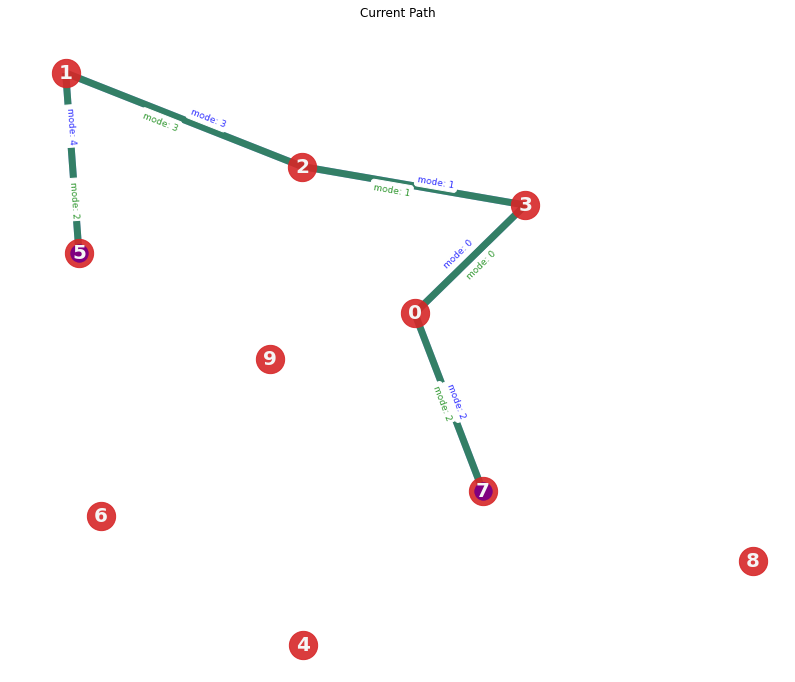

In [ ]:
world.step(user_action=user_action)
world.display_path()

AI assistant

In [ ]:
AI = Assistant()
AI.observe(world)